# 🇪🇬 EgySentiment: Hybrid Training (Phase 2.5) - Llama 3.1 Edition

**Author:** AI Research Scientist  
**Goal:** Fine-tune `Llama-3.1-8b-Instruct` (Latest SOTA) using a **Hybrid Dataset** with **Oversampling**.
**Environment:** Google Colab Pro (A100/V100/T4)  
**Storage:** Hybrid (Local Processing + Drive Backup)

### 🚀 Upgrades
1.  **Model:** Upgraded to **Llama 3.1 8B** (Smarter, better reasoning).
2.  **Safety:** Adapters saved to Drive immediately.
3.  **Stability:** Local GGUF conversion.

### 🔧 Hyperparameters
*   `max_steps`: **120**
*   `warmup_steps`: **10**
*   `learning_rate`: **2e-4**
*   `lr_scheduler_type`: **cosine**

## 1. Setup & Drive Mount

In [ ]:
from google.colab import drive
import os

# --- MOUNT GOOGLE DRIVE ---
print("📂 Mounting Google Drive...")
drive.mount('/content/drive')

# Create Output Directory in Drive
DRIVE_DIR = "/content/drive/MyDrive/EgySentiment_Model"
os.makedirs(DRIVE_DIR, exist_ok=True)
print(f"✅ Drive Directory: {DRIVE_DIR}")

📂 Mounting Google Drive...
Mounted at /content/drive
✅ Drive Directory: /content/drive/MyDrive/EgySentiment_Model


In [ ]:
%%capture
# Install Unsloth, Xformers (Flash Attention), and other deps
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes
!pip install scikit-learn matplotlib seaborn datasets

In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048
dtype = None
load_in_4bit = True

# --- UPGRADE: Using Llama 3.1 8B ---
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.4: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

## 2. Data Loading (Hybrid + Oversampling)

In [ ]:
import json
from datasets import load_dataset, Dataset, concatenate_datasets
import pandas as pd

# --- 1. Load Financial PhraseBank (General Finance) ---
print("📚 Loading Financial PhraseBank...")
try:
    phrasebank = load_dataset("gtfintechlab/financial_phrasebank_sentences_allagree", "5768", split="train")
except Exception as e:
    print(f"⚠️ Error loading PhraseBank: {e}")
    phrasebank = load_dataset("financial_phrasebank", "sentences_allagree", split="train", trust_remote_code=True)

# --- 2. Load Local Egyptian Data ---
print("🇪🇬 Loading Local Egyptian Data...")
dataset_path = "testing_data.jsonl"
local_data = []

try:
    with open(dataset_path, 'r', encoding='utf-8') as f:
        for line in f:
            local_data.append(json.loads(line))

    local_df = pd.DataFrame(local_data)
    local_dataset = Dataset.from_pandas(local_df)
    print(f"✓ Loaded {len(local_dataset)} local samples")

    # Split Local Data: 50% Train (to mix), 50% Test (to evaluate)
    local_split = local_dataset.train_test_split(test_size=0.5, seed=42)
    local_train = local_split["train"]
    local_test = local_split["test"]
    print(f"  - Local Train: {len(local_train)} (Will be oversampled)")
    print(f"  - Local Test:  {len(local_test)} (Reserved for evaluation)")

except FileNotFoundError:
    print("⚠️ 'testing_data.jsonl' not found. Using dummy data.")
    local_train = Dataset.from_dict({"text": [], "sentiment": [], "reasoning": []})
    local_test = Dataset.from_dict({"text": [], "sentiment": [], "reasoning": []})

# --- 3. Format Prompts ---
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Analyze the sentiment of the following financial news. Provide the sentiment (positive/negative/neutral) and a brief reasoning.

### Input:
{}

### Response:
{{"sentiment": "{}", "reasoning": "{}"}}"""

EOS_TOKEN = tokenizer.eos_token

def format_phrasebank(examples):
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    inputs = examples["sentence"]
    labels = examples["label"]
    texts = []
    for input_text, label in zip(inputs, labels):
        sentiment = label_map[label]
        text = alpaca_prompt.format(input_text, sentiment, "Sentiment inferred from financial context.") + EOS_TOKEN
        texts.append(text)
    return {"text": texts}

def format_local(examples):
    inputs = examples["text"]
    sentiments = examples["sentiment"]
    reasonings = examples["reasoning"]
    texts = []
    for input_text, sentiment, reasoning in zip(inputs, sentiments, reasonings):
        text = alpaca_prompt.format(input_text, sentiment, reasoning) + EOS_TOKEN
        texts.append(text)
    return {"text": texts, "ground_truth_sentiment": sentiments}

# Apply Formatting
print("🔄 Formatting datasets...")
phrasebank_formatted = phrasebank.map(format_phrasebank, batched=True)
local_train_formatted = local_train.map(format_local, batched=True)
local_test_formatted = local_test.map(format_local, batched=True)

# --- 4. Create Hybrid Training Set with OVERSAMPLING ---
# Remove extra columns
phrasebank_formatted = phrasebank_formatted.select_columns(["text"])
local_train_formatted = local_train_formatted.select_columns(["text"])

# OVERSAMPLE: Repeat local data 10 times to give it weight against PhraseBank
oversample_factor = 10
local_train_oversampled = concatenate_datasets([local_train_formatted] * oversample_factor)
print(f"📈 Oversampling Local Data: {len(local_train_formatted)} -> {len(local_train_oversampled)} samples")

# Combine
train_dataset = concatenate_datasets([phrasebank_formatted, local_train_oversampled])
train_dataset = train_dataset.shuffle(seed=42) # Shuffle to mix sources

print(f"\n✅ Final Hybrid Training Set: {len(train_dataset)} samples")
print(f"✅ Final Test Set (Egyptian): {len(local_test_formatted)} samples")

📚 Loading Financial PhraseBank...


README.md: 0.00B [00:00, ?B/s]

5768/train-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

5768/test-00000-of-00001.parquet:   0%|          | 0.00/60.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1584 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/680 [00:00<?, ? examples/s]

🇪🇬 Loading Local Egyptian Data...
✓ Loaded 302 local samples
  - Local Train: 151 (Will be oversampled)
  - Local Test:  151 (Reserved for evaluation)
🔄 Formatting datasets...


Map:   0%|          | 0/1584 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

📈 Oversampling Local Data: 151 -> 1510 samples

✅ Final Hybrid Training Set: 3094 samples
✅ Final Test Set (Egyptian): 151 samples


## 3. Model Configuration (LoRA)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2025.11.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## 4. Training (Optimized for Pro)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# --- PRO FEATURE: Auto-Detect GPU for Batch Size ---
gpu_name = torch.cuda.get_device_name(0)
print(f"🚀 Detected GPU: {gpu_name}")

if "A100" in gpu_name:
    BATCH_SIZE = 8
    GRAD_ACCUM = 1
    print("⚡ A100 Detected! Boosting Batch Size to 8.")
elif "V100" in gpu_name:
    BATCH_SIZE = 4
    GRAD_ACCUM = 2
    print("⚡ V100 Detected! Boosting Batch Size to 4.")
else:
    BATCH_SIZE = 2
    GRAD_ACCUM = 4
    print("🐢 T4/P100 Detected. Using Standard Batch Size 2.")

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = BATCH_SIZE,
        gradient_accumulation_steps = GRAD_ACCUM,
        warmup_steps = 10,
        max_steps = 120,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
    ),
)

trainer_stats = trainer.train()

🚀 Detected GPU: NVIDIA A100-SXM4-80GB
⚡ A100 Detected! Boosting Batch Size to 8.


Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/3094 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,094 | Num Epochs = 1 | Total steps = 120
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: seifhegazy2003 (seifhegazy2003-eui) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.603200
2,2.544600
3,2.284700
4,2.315400
5,2.494800
6,2.350700
7,2.320200
8,2.068100
9,2.151100
10,2.070000


train/epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇███
train/grad_norm,▄▇▃▄▁▇▅▁▃▂▂▁▄▃▃▄▁▃▂▃▇▃▂▂▃▅▃▅▅▅▃▃▄█▄▅▅▅▃▆
train/learning_rate,▂▃▅▅▆█████▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
train/loss,█▇▆▄▄▂▄▄▃▃▃▂▃▅▃▃▃▃▃▂▂▃▁▂▂▂▃▃▃▃▃▂▂▂▃▁▃▂▃▂
total_flos,2.7251678933090304e+16
train/epoch,0.31008
train/global_step,120
train/grad_norm,0.78935
train/learning_rate,0.0
train/loss,1.1836


## 5. Evaluation on Egyptian Data

Running inference on 151 Egyptian samples...


 17%|█▋        | 26/151 [01:18<04:31,  2.17s/it]Unsloth: Input IDs of shape torch.Size([1, 2219]) with length 2219 > the model's max sequence length of 2048.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████| 151/151 [07:56<00:00,  3.16s/it]



🇪🇬 Egyptian Data Performance Report (Hybrid + Oversampled Model):
              precision    recall  f1-score   support

    positive       0.85      0.91      0.88        97
     neutral       0.66      0.54      0.59        39
    negative       0.69      0.73      0.71        15

    accuracy                           0.79       151
   macro avg       0.73      0.73      0.73       151
weighted avg       0.79      0.79      0.79       151



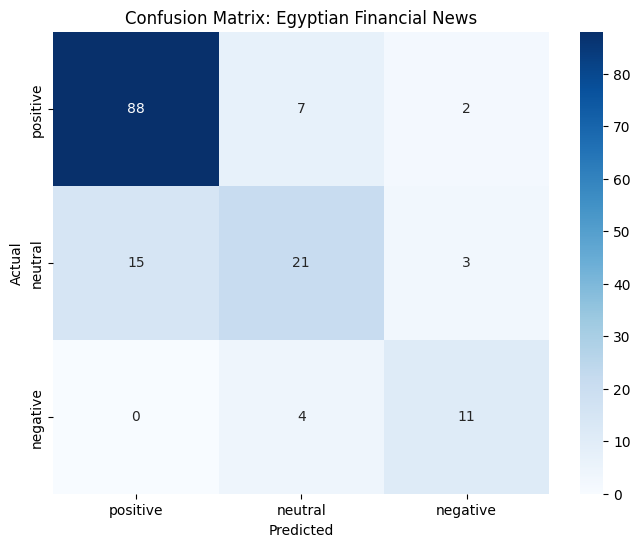

In [ ]:
FastLanguageModel.for_inference(model)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

y_true = []
y_pred = []

print(f"Running inference on {len(local_test_formatted)} Egyptian samples...")

for i in tqdm(range(len(local_test_formatted))):
    # Prepare input
    input_text = local_test_formatted[i]["text"].split("### Response:")[0] + "### Response:\n"
    ground_truth = local_test_formatted[i]["ground_truth_sentiment"]

    inputs = tokenizer([input_text], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
    response = tokenizer.batch_decode(outputs)[0]

    try:
        generated_part = response.split("### Response:")[1]
        match = re.search(r'"sentiment":\s*"(positive|negative|neutral)"', generated_part, re.IGNORECASE)
        if match:
            pred_sentiment = match.group(1).lower()
        else:
            pred_sentiment = "neutral"
    except:
        pred_sentiment = "neutral"

    y_true.append(ground_truth)
    y_pred.append(pred_sentiment)

# Metrics
print("\n🇪🇬 Egyptian Data Performance Report (Hybrid + Oversampled Model):")
print(classification_report(y_true, y_pred, labels=["positive", "neutral", "negative"]))

cm = confusion_matrix(y_true, y_pred, labels=["positive", "neutral", "negative"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["positive", "neutral", "negative"],
            yticklabels=["positive", "neutral", "negative"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Egyptian Financial News')
plt.show()

## 6. Export to Google Drive (Safe Mode)

In [ ]:
import os
import shutil
import subprocess
import gc
import torch

# Cleanup memory
gc.collect()
torch.cuda.empty_cache()

# --- 1. Manual Merge ---
print("🔄 Manually merging LoRA weights...")
MERGED_DIR = "merged_model"
if os.path.exists(MERGED_DIR):
    shutil.rmtree(MERGED_DIR)

# Save the merged model to disk (16-bit)
model.save_pretrained_merged(
    MERGED_DIR,
    tokenizer,
    save_method = "merged_16bit",
)
# CRITICAL FIX: Explicitly save tokenizer to ensure convert script finds Llama 3 vocab
tokenizer.save_pretrained(MERGED_DIR)
print(f"✅ Model merged to directory: {MERGED_DIR}")

# --- 2. Setup Official Llama.cpp (CMake Build) ---
print("\n🛠️ Setting up official Llama.cpp...")
if os.path.exists("llama.cpp"):
    shutil.rmtree("llama.cpp")

!git clone https://github.com/ggerganov/llama.cpp

# FIX: Install specific dependencies to avoid conflicts, then update transformers
!pip install -q gguf protobuf sentencepiece
!pip install -q -U transformers  # Update transformers to fix 'model_type' error

# Build using CMake (Fix for Makefile error)
print("\n🏗️ Building llama.cpp with CMake...")
!cmake -B llama.cpp/build -S llama.cpp -DGGML_CUDA=ON
!cmake --build llama.cpp/build --config Release -j 4

# --- 3. Convert to GGUF (F16) ---
print("\n⚙️ Converting to GGUF (F16)...")
GGUF_F16_FILE = "model-unsloth.F16.gguf"

# Run official conversion script
!python llama.cpp/convert_hf_to_gguf.py {MERGED_DIR} --outfile {GGUF_F16_FILE} --outtype f16

# --- 4. Quantize to 4-bit (q4_k_m) ---
print("\n📉 Quantizing to q4_k_m...")
FINAL_GGUF_FILE = "EgySentiment-Llama3.1-8B.Q4_K_M.gguf"
# Binary location changes with CMake build
QUANTIZE_BIN = "llama.cpp/build/bin/llama-quantize"

if not os.path.exists(QUANTIZE_BIN):
    print(f"⚠️ Quantize binary not found at {QUANTIZE_BIN}. Checking build directory...")
    !find llama.cpp/build -name llama-quantize

# Run quantization
!{QUANTIZE_BIN} {GGUF_F16_FILE} {FINAL_GGUF_FILE} q4_k_m

# --- 5. Save to Drive ---
print(f"\n🚚 Moving {FINAL_GGUF_FILE} to Google Drive...")
if os.path.exists(FINAL_GGUF_FILE):
    dest_path = os.path.join(DRIVE_DIR, FINAL_GGUF_FILE)
    shutil.copy(FINAL_GGUF_FILE, dest_path)
    print(f"✅ Saved to: {dest_path}")
else:
    print("❌ Conversion failed. GGUF file not created.")

print("\n🎉 Manual GGUF Conversion Complete!")

🔄 Manually merging LoRA weights...
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  25%|██▌       | 1/4 [00:23<01:10, 23.66s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 2/4 [01:00<01:02, 31.14s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  75%|███████▌  | 3/4 [01:13<00:22, 22.92s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 4/4 [01:15<00:00, 18.89s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [01:06<00:00, 16.54s/it]


Unsloth: Merge process complete. Saved to `/content/merged_model`
✅ Model merged to directory: merged_model

🛠️ Setting up official Llama.cpp...
Cloning into 'llama.cpp'...
remote: Enumerating objects: 69628, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 69628 (delta 44), reused 22 (delta 22), pack-reused 69560 (from 3)
Receiving objects: 100% (69628/69628), 211.50 MiB | 38.38 MiB/s, done.
Resolving deltas: 100% (50458/50458), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 74.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.11.5 requires transformers!=4.52.0,!=4.52.1,!=4.52.2,!=4.52.3,!=4.53.0,!=4.54.0,!=4.55.0,!=4.55.1,<=4.57.2,>=4.51.3, but you have transformers 

In [23]:
from google.colab import files
import shutil

# --- 1. Save & Download LoRA Adapters (Lightweight Version) ---
print("💾 Saving LoRA adapters separately...")
model.save_pretrained("lora_adapters")
tokenizer.save_pretrained("lora_adapters")

print("📦 Zipping adapters...")
!zip -r lora_adapters.zip lora_adapters

print("⬇️ Downloading LoRA Adapters (zip)...")
files.download("lora_adapters.zip")

# --- 2. Download GGUF Model (Full Quantized Version) ---
# Note: This file is large (~5GB). If this fails, download from Google Drive.
GGUF_FILE = "EgySentiment-Llama3.1-8B.Q4_K_M.gguf"
if os.path.exists(GGUF_FILE):
    print(f"⬇️ Downloading GGUF Model: {GGUF_FILE}...")
    files.download(GGUF_FILE)
else:
    print("⚠️ GGUF file not found in local runtime. Check Drive.")

💾 Saving LoRA adapters separately...
📦 Zipping adapters...
  adding: lora_adapters/ (stored 0%)
  adding: lora_adapters/tokenizer_config.json (deflated 96%)
  adding: lora_adapters/chat_template.jinja (deflated 72%)
  adding: lora_adapters/tokenizer.json (deflated 85%)
  adding: lora_adapters/adapter_config.json (deflated 58%)
  adding: lora_adapters/special_tokens_map.json (deflated 71%)
  adding: lora_adapters/adapter_model.safetensors (deflated 7%)
  adding: lora_adapters/README.md (deflated 65%)
⬇️ Downloading LoRA Adapters (zip)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Downloading GGUF Model: EgySentiment-Llama3.1-8B.Q4_K_M.gguf...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>